Importing Important Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt



Box Plot and Histogram of Raw Data

In [2]:
raw_data = pd.read_csv('../input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')
raw_data.shape #Dimensions of Dataset
raw_data.head()

raw_data.isna().sum() # checking na values in each column for null value treatment

final_data = raw_data[['name','host_id','host_name','neighbourhood_group','neighbourhood','latitude','longitude','room_type','price','availability_365','calculated_host_listings_count','number_of_reviews']] # selecting relevant columns
values = {'name': 'unknown_name', 'host_name': 'unknown_host_name'} # list to fill dummy values at null data points
final_data= final_data.fillna(value=values) # filling the null values with dummy names
final_data.isna().sum() # no null values now
final_data.shape


final_data['price'].quantile([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,.91,.92,.93,.94,.95,.96,.97,.98,.99,1])

# box plot of unprocessed data
fig = px.box(final_data,y = 'price', notched=True)
fig.show()

fig = px.histogram(final_data, x="price",nbins = 100 )
fig.update_layout(showlegend = False)
fig.show()

Outlier Treatment

In [3]:
# checking quantiles for price distrbution to detect outliers

Q1 = final_data['price'].quantile(.25)
Q3 = final_data['price'].quantile(.75)
IQR = Q3 - Q1
lower_price_bound = Q1 - 1.5*IQR
upper_price_bound = Q3 + 1.5*IQR


# Capping the data between lower_price_bound(0) and upper_price_bound(334)
data_upper_bound_cutoff = final_data[final_data[final_data['price']>=lower_price_bound]['price']<=upper_price_bound]
data_upper_bound_cutoff.shape


#45923 outlier upper bound


fig = px.histogram(data_upper_bound_cutoff, x="price",nbins = 20 )
fig.update_layout(showlegend = False)
fig.show()


Cutting the Data off at 95 Percentile

In [4]:
percentile_95 = final_data['price'].quantile(.95)

data_95_percentile_cutoff = final_data[final_data[final_data['price']>=lower_price_bound]['price']<=percentile_95]
data_95_percentile_cutoff.shape


#46454 95 percentile  bound

# Histogram
fig = px.histogram(data_95_percentile_cutoff, x="price",nbins = 20 )
fig.update_layout(showlegend = False)
fig.show()


Basic Data Analysis Based on Room Type and Neighbourhood

In [5]:
#Finally deciding to go with outlier selection model.

final_data = data_upper_bound_cutoff
final_data.shape
# 45923 rows

final_data.head()


# Room Type booking count analysis
'''
room_type_data =final_data.pivot_table('price', ['room_type'], aggfunc='count').reset_index()
fig = px.bar(room_type_data, x='room_type', y='price')

fig.update_layout(
    xaxis_title="Room Type",
    yaxis_title="Booking Count"
)

fig.show()
#Booking for shared room is the lowest
'''
roomdf = final_data.groupby('room_type').size()/final_data['room_type'].count()*100
labels = roomdf.index
values = roomdf.values


fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.2)])
fig.show()


location_subset_data = final_data[['neighbourhood_group','neighbourhood']].drop_duplicates()
location_subset_data = location_subset_data.pivot_table('neighbourhood',['neighbourhood_group'],aggfunc='count').reset_index()
fig = px.bar(location_subset_data, x='neighbourhood_group', y='neighbourhood')
fig.update_layout(
    xaxis_title="Neighbourhood_group",
    yaxis_title="Neighbourhood count"
)
fig.show()





Neighbourhood,Avg Price and Airbnb Location Analysis

In [6]:
# Neighbour hood group analysis
'''
neighbourhood_group_subset_data = final_data[['neighbourhood_group','name']].drop_duplicates()
neighbourhood_group_subset_data = neighbourhood_group_subset_data.pivot_table('name',['neighbourhood_group'],aggfunc='count').reset_index()
fig = px.bar(neighbourhood_group_subset_data, x='neighbourhood_group', y='name')
fig.update_layout(
    xaxis_title="Neighbourhood_group",
    yaxis_title="airbnb location count"
)
fig.show()



neighbour_group_data =final_data.pivot_table('price', ['neighbourhood_group'], aggfunc='mean').reset_index()
fig = px.bar(neighbour_group_data, x='neighbourhood_group', y='price')
fig.show()
# the avg price at manhatten is the highest
'''



fig = px.box(final_data,y = 'price',x = 'neighbourhood_group', notched=True)
fig.show()



neighbour_group_df1 =final_data.pivot_table(['name'] , ['neighbourhood_group'], aggfunc='count').reset_index()
neighbour_group_df2 =final_data.pivot_table(['price'] , ['neighbourhood_group'], aggfunc='mean').reset_index()
neighbour_group_df = pd.merge(neighbour_group_df1, neighbour_group_df2, on='neighbourhood_group')
neighbour_group_df = neighbour_group_df.rename(columns={'neighbourhood_group':'neighbourhood_group','name':'airbnb_count','price':'price'})
fig = px.bar(neighbour_group_df, x='neighbourhood_group', y='price',color = 'airbnb_count')
fig.update_layout(showlegend = False,title = "Neighbourhood_group vs (Average Price and count of Airbnb locations)")
fig.show()



#options = ['Brooklyn','Manhatten'] 
#final_data_subset = final_data[final_data['neighbourhood_group'].isin(options)]
neighbour_df1 =final_data.pivot_table(['name'] , ['neighbourhood'], aggfunc='count').reset_index()
neighbour_df2 =final_data.pivot_table(['price'] , ['neighbourhood'], aggfunc='mean').reset_index()
neighbour_df = pd.merge(neighbour_df1, neighbour_df2, on='neighbourhood')
neighbour_df = neighbour_df.rename(columns={'neighbourhood':'neighbourhood','name':'airbnb_count','price':'price'})
#neighbour_df = neighbour_df[neighbour_df['neighbourhood']=='Astoria']
fig = px.scatter(neighbour_df, x="neighbourhood", y="price",color = 'airbnb_count',
                 size='price')
fig.update_layout(showlegend = False,title = "Neighbourhood vs (Average Price and count of Airbnb locations)")
fig.show()
#219 points









In [7]:
host_df1 =final_data.pivot_table(['price'] , ['host_id'], aggfunc='mean').reset_index()
host_df2 =final_data.pivot_table(['number_of_reviews'] , ['host_id'], aggfunc='sum').reset_index()
host_df = pd.merge(host_df1, host_df2, on='host_id')

host_df = host_df.rename(columns={'host_id':'host_id','number_of_reviews':'total_reviews','price':'avg_price'})
#neighbour_df = neighbour_df[neighbour_df['neighbourhood']=='Astoria']
fig = px.scatter(host_df, x="host_id", y="total_reviews",color = 'avg_price')
fig.update_layout(showlegend = False,title = "host_id vs (Average Price and sum of host reviews)")
fig.show()
host_df['avg_price'].max()


334.0

Airbnb Geography Analysis

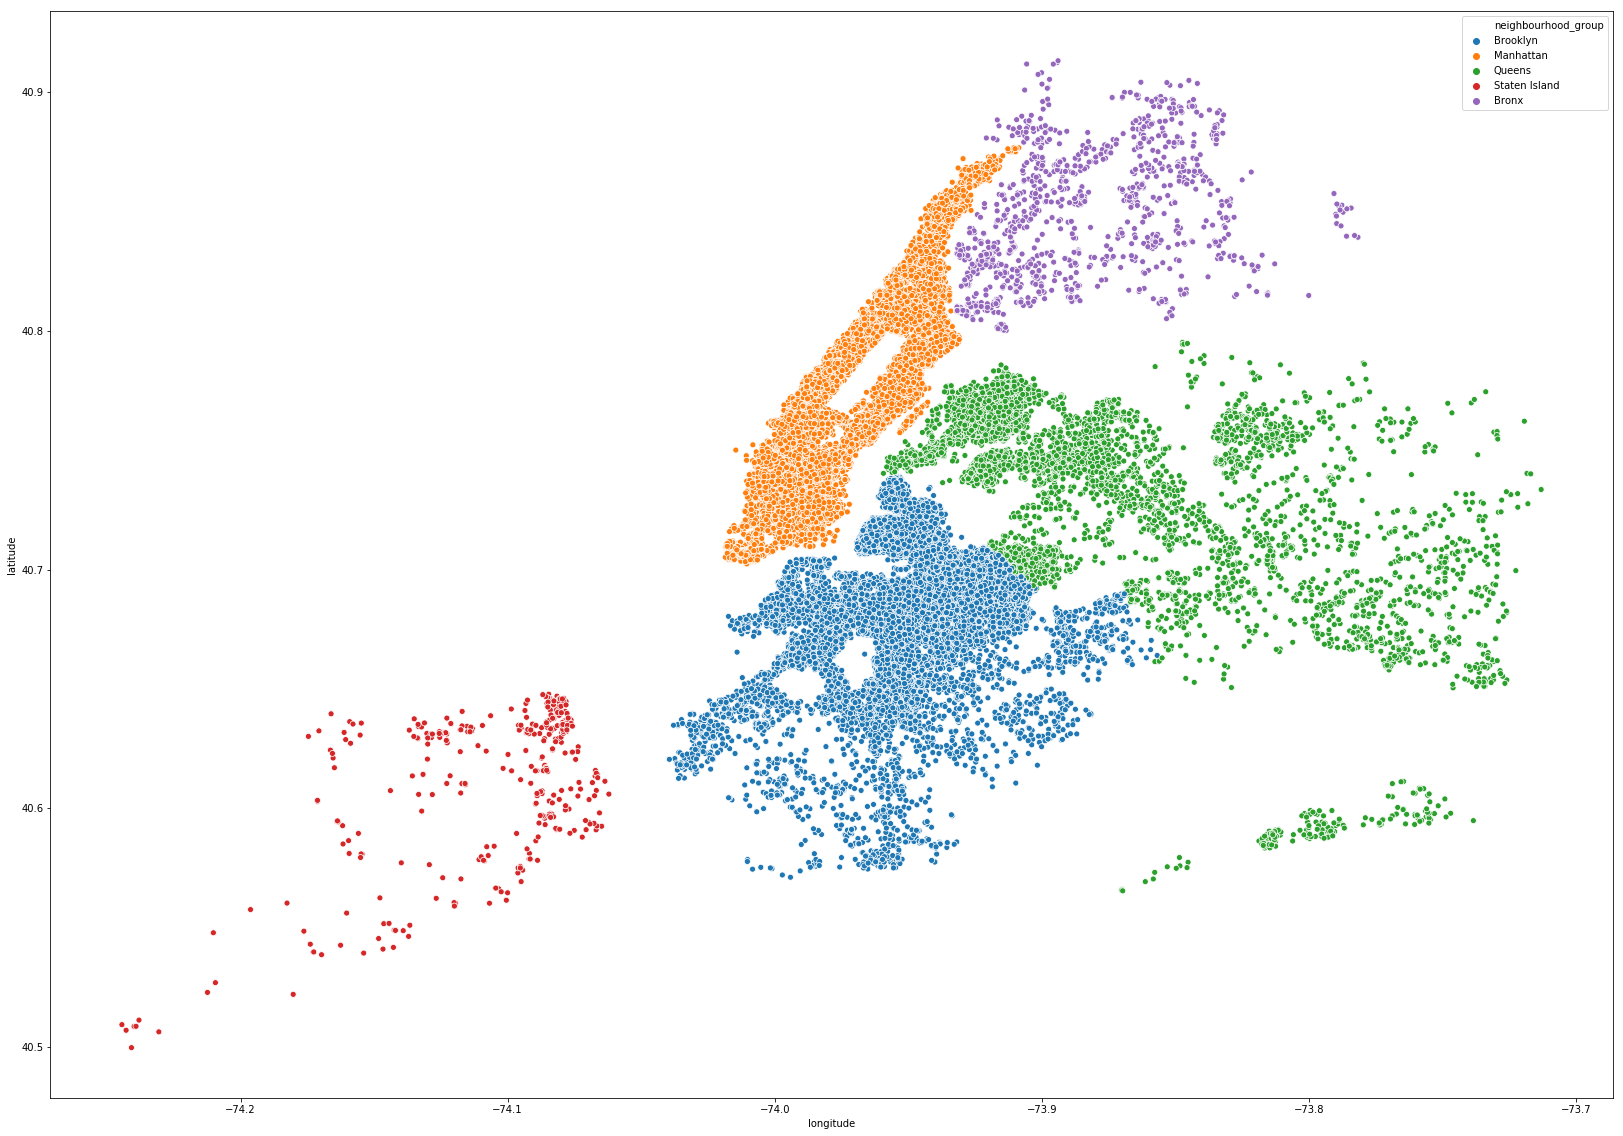

In [8]:
f,ax = plt.subplots(figsize=(28,20))
ax = sns.scatterplot(y=final_data['latitude'],x=final_data['longitude'],hue=final_data['neighbourhood_group'])
plt.show()

Airbnb Geography vs Price Analysis

In [9]:
lat_long_subset_data = final_data[final_data['neighbourhood_group']=='Manhattan'][['latitude','longitude','price']].drop_duplicates()
#lat_long_subset_data = lat_long_subset_data.pivot_table('price',['latitude','longitude'],aggfunc='average').reset_index()
fig = px.scatter(lat_long_subset_data, x="latitude", y="longitude",color = 'price')
fig.update_layout(
    xaxis_title="Latitude",
    yaxis_title="Longitude",
    title = 'Manhattan LatLong vs Price Plot'
)
fig.show()

lat_long_subset_data = final_data[final_data['neighbourhood_group']=='Brooklyn'][['latitude','longitude','price']].drop_duplicates()
#lat_long_subset_data = lat_long_subset_data.pivot_table('price',['latitude','longitude'],aggfunc='average').reset_index()
fig = px.scatter(lat_long_subset_data, x="latitude", y="longitude",color = 'price')
fig.update_layout(
    xaxis_title="Latitude",
    yaxis_title="Longitude",
    title = 'Brooklyn LatLong vs Price Plot'
)
fig.show()

lat_long_subset_data = final_data[final_data['neighbourhood_group']=='Bronx'][['latitude','longitude','price']].drop_duplicates()
#lat_long_subset_data = lat_long_subset_data.pivot_table('price',['latitude','longitude'],aggfunc='average').reset_index()
fig = px.scatter(lat_long_subset_data, x="latitude", y="longitude",color = 'price')
fig.update_layout(
    xaxis_title="Latitude",
    yaxis_title="Longitude",
    title = 'Bronx LatLong vs Price Plot'
)
fig.show()

lat_long_subset_data = final_data[final_data['neighbourhood_group']=='Queens'][['latitude','longitude','price']].drop_duplicates()
#lat_long_subset_data = lat_long_subset_data.pivot_table('price',['latitude','longitude'],aggfunc='average').reset_index()
fig = px.scatter(lat_long_subset_data, x="latitude", y="longitude",color = 'price')
fig.update_layout(
    xaxis_title="Latitude",
    yaxis_title="Longitude",
    title = 'Queens LatLong vs Price Plot'
)
fig.show()

lat_long_subset_data = final_data[final_data['neighbourhood_group']=='Staten Island'][['latitude','longitude','price']].drop_duplicates()
#lat_long_subset_data = lat_long_subset_data.pivot_table('price',['latitude','longitude'],aggfunc='average').reset_index()
fig = px.scatter(lat_long_subset_data, x="latitude", y="longitude",color = 'price')
fig.update_layout(
    xaxis_title="Latitude",
    yaxis_title="Longitude",
    title = 'Staten Island LatLong vs Price Plot'
)
fig.show()
